<a href="https://colab.research.google.com/github/malavikakrishnamurthy/ArtandMLProject2/blob/main/The_Modern_Venus_Project_Group_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STROTSS Style Transfer Notebook

#### [Style Transfer by Relaxed Optimal Transport and Self-Similarity (STROTSS)](https://arxiv.org/abs/1904.12785)

Code from: https://github.com/futscdav/strotss

For use in project by Anna Gerchanovsky, Gaia Rajan, Saniya Singh, Malavika Krishnamurthy, notebook originally compiled by Peter Schalenbrand.


In [ ]:
#@title Download the strotss code from GitHub

import os
if not os.path.exists('/content/strotss'):
    !git clone https://github.com/futscdav/strotss.git
os.chdir('/content/strotss')
from strotss import *

Cloning into 'strotss'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 13), reused 36 (delta 8), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [ ]:
#@title Helper Functions
import torch
import requests
import PIL.Image
from io import BytesIO
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if not torch.cuda.is_available():
    print('YOU ARE NOT USING A GPU.  IT\'S GONNA BE REAAALLLLY SLOW')
    print('Go to the top of the page.  Click Runtime -> Change Runtime Type -> Hardware accelerator')
    print('From the dropdown, select GPU and rerun all this stuff')

def pil_loader_internet(url):
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    return img.convert('RGB')

def show_img(img):
    # Code for displaying at actual resolution from:
    # https://stackoverflow.com/questions/28816046/displaying-different-images-with-actual-size-in-matplotlib-subplot
    dpi = 80
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_style_and_content(style, content):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(content)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Content')
    ax[1].imshow(style)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Style')
    plt.show()

In [ ]:
#@title Define STROTSS function
# Redefine the STROTSS function to put some debugging statements in

def strotss(content_pil, style_pil, content_weight=1.0*16.0, device='cuda:0', space='uniform'):
    content_np = pil_to_np(content_pil)
    style_np = pil_to_np(style_pil)
    content_full = np_to_tensor(content_np, space).to(device)
    style_full = np_to_tensor(style_np, space).to(device)

    lr = 2e-3
    extractor = Vgg16_Extractor(space=space).to(device)

    scale_last = max(content_full.shape[2], content_full.shape[3])
    scales = []

    for scale in range(10):
        divisor = 2**scale
        if min(content_pil.width, content_pil.height) // divisor >= 33:
            scales.insert(0, divisor)
    
    clow = -1.0 if space == 'uniform' else -1.7
    chigh = 1.0 if space == 'uniform' else 1.7

    for scale in scales:
        # rescale content to current scale
        content = tensor_resample(content_full, [ content_full.shape[2] // scale, content_full.shape[3] // scale ])
        style = tensor_resample(style_full, [ style_full.shape[2] // scale, style_full.shape[3] // scale ])
        print(f'Optimizing at resoluton [{content.shape[2]}, {content.shape[3]}]')

        # upsample or initialize the result
        if scale == scales[0]:
            # first
            result = laplacian(content) + style.mean(2,keepdim=True).mean(3,keepdim=True)
        elif scale == scales[-1]:
            # last 
            result = tensor_resample(result, [content.shape[2], content.shape[3]])
            lr = 1e-3
        else:
            result = tensor_resample(result, [content.shape[2], content.shape[3]]) + laplacian(content)

        # do the optimization on this scale
        result = optimize(result, content, style, scale, content_weight=content_weight, lr=lr, extractor=extractor)

        # Show intermediate result
        result_image = tensor_to_np(torch.clamp(result, clow, chigh)) # 
        # renormalize image
        result_image -= result_image.min()
        result_image /= result_image.max()
        show_img(result_image)

        # next scale lower weight
        content_weight /= 2.0

    result_image = tensor_to_np(tensor_resample(torch.clamp(result, clow, chigh), [content_full.shape[2], content_full.shape[3]])) # 
    # renormalize image
    result_image -= result_image.min()
    result_image /= result_image.max()
    return np_to_pil(result_image * 255.)

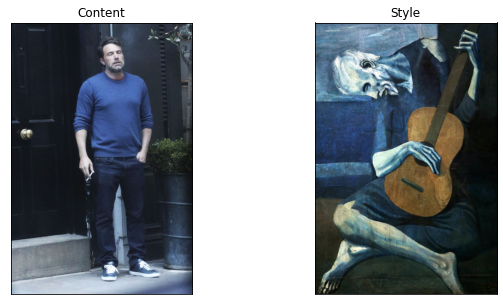

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Optimizing at resoluton [64, 42]


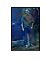

Optimizing at resoluton [128, 85]


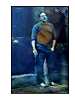

Optimizing at resoluton [256, 170]


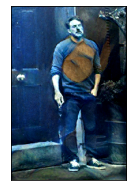

Optimizing at resoluton [512, 341]


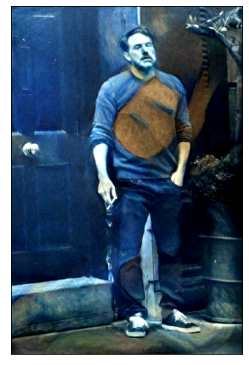

Optimizing at resoluton [1024, 682]


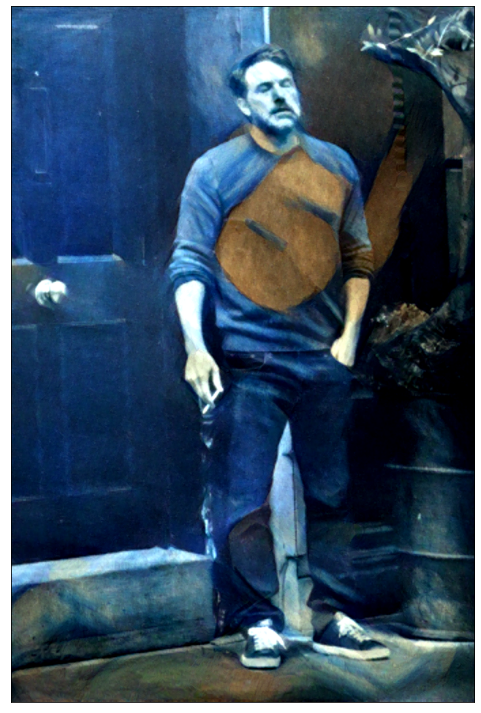

Final Result


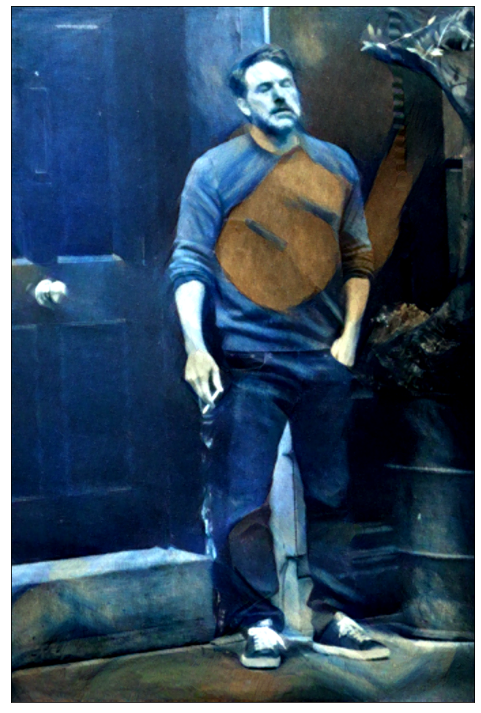

In [ ]:
#@title Run STROTSS
#@markdown Put publicly accessible URLs to images for content_url and style_url
content_url = 'https://pyxis.nymag.com/v1/imgs/2e7/5d7/73e020f56c4a86221823bc32113b4316d2-25-ben-affleck-sad-smoke.2x.w710.jpg'  #@param {type:"string"}
style_url = 'https://1.bp.blogspot.com/-dAahV8ICa6A/Xi3uFh77VrI/AAAAAAAAAWs/zDZpox79czwcR0KHL-svnprtgpmlK5ixQCLcBGAsYHQ/s1600/the-old-guitarist-by-pablo-picasso-1903-1904.jpg'  #@param {type:"string"}

content_pil = pil_loader_internet(content_url)
style_pil = pil_loader_internet(style_url)
plot_style_and_content(style_pil, content_pil)

max_width = 1024  #@param {type:"integer"}

#@markdown How much weight to give to content. 
content_weight = 0.75 #@param {type:"number"}
content_weight *= 16.0 

result = strotss(pil_resize_long_edge_to(content_pil, max_width), 
        pil_resize_long_edge_to(style_pil, max_width), 
        content_weight, device, "vgg")
print('Final Result')
show_img(pil_to_np(result))



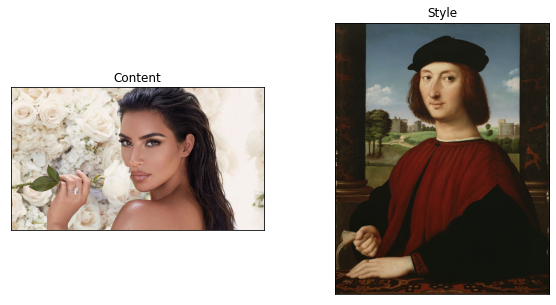

Optimizing at resoluton [36, 64]


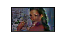

Optimizing at resoluton [72, 128]


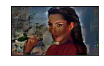

Optimizing at resoluton [144, 256]


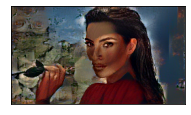

Optimizing at resoluton [288, 512]


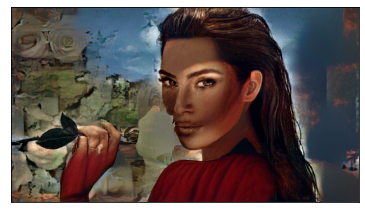

Optimizing at resoluton [576, 1024]


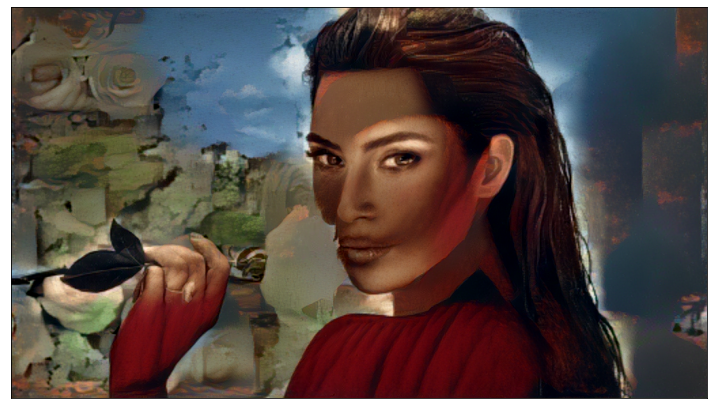

Final Result


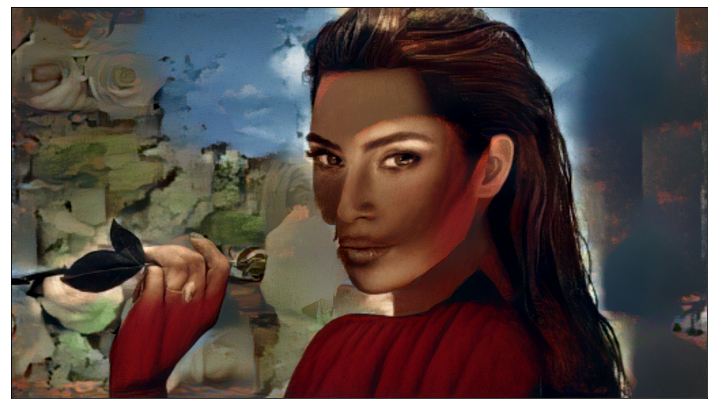

In [ ]:
#@title Run STROTSS
#@markdown Put publicly accessible URLs to images for content_url and style_url
content_url = 'https://fotos.perfil.com/2020/02/13/trim/1280/720/kim-kardashian-west-915611.jpg'  #@param {type:"string"}
style_url = 'http://blogs.getty.edu/iris/files/2016/09/portrait_young_man_1300.jpg?x45884'  #@param {type:"string"}

content_pil = pil_loader_internet(content_url)
style_pil = pil_loader_internet(style_url)
plot_style_and_content(style_pil, content_pil)

max_width = 1024  #@param {type:"integer"}

#@markdown How much weight to give to content. 
content_weight = 0.75 #@param {type:"number"}
content_weight *= 16.0 

result = strotss(pil_resize_long_edge_to(content_pil, max_width), 
        pil_resize_long_edge_to(style_pil, max_width), 
        content_weight, device, "vgg")
print('Final Result')
show_img(pil_to_np(result))